In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from typing import Tuple, Optional
from simulation_backend import Simulation, Scenario, ScenarioParameters

plt.style.use('ggplot')

In [26]:
num_simulations = 100
T = 7*16
T_control = 7*12

In [27]:
rhos = np.linspace(0, 1, num=6)
list(rhos)

[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

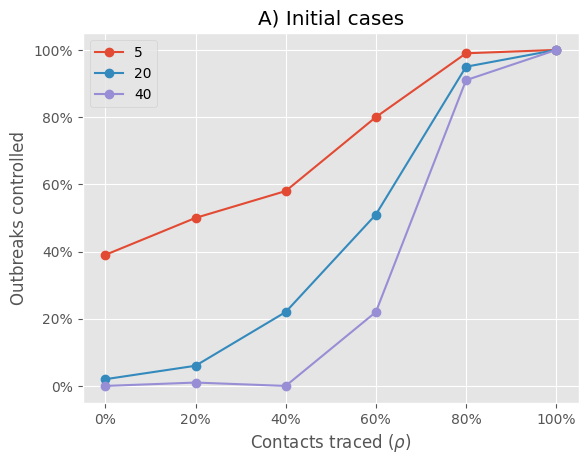

In [10]:
fig, ax = plt.subplots(1)

for initial_cases in [5, 20, 40]:
    average_controlled_outbreaks = []
    for rho in rhos:
        params = ScenarioParameters(T = T, 
                            T_control = T_control,
                            initial_cases = initial_cases,
                            rho = rho,
                            R_0 = 2.5,
                            onset_to_isolation = "short",
                            transmission_before_symptoms_percentage = 15,
                            subclinical_prob = 0)
        scen = Scenario(params)
        stats = scen.run_simulations(num_simulations = num_simulations)
        average_controlled_outbreaks.append(stats.controlled_percentage)
    plt.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=initial_cases)
        
plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("A) Initial cases")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()

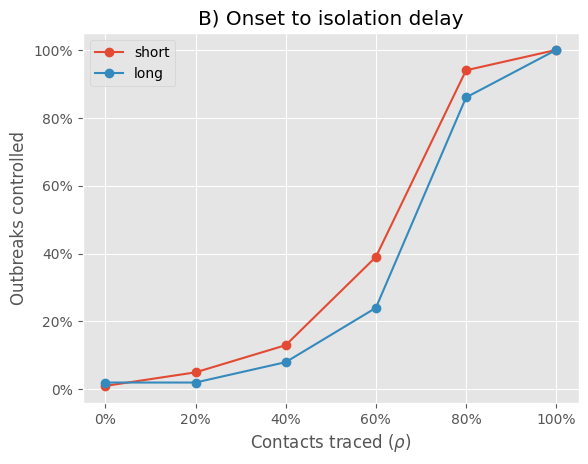

In [11]:
fig, ax = plt.subplots(1)

for onset_to_isolation in ["short", "long"]:
    average_controlled_outbreaks = []
    for rho in rhos:
        params = ScenarioParameters(T = T, 
                            T_control = T_control,
                            initial_cases = 20,
                            rho = rho,
                            R_0 = 2.5,
                            onset_to_isolation = onset_to_isolation,
                            transmission_before_symptoms_percentage = 15,
                            subclinical_prob = 0)
        scen = Scenario(params)
        stats = scen.run_simulations(num_simulations = num_simulations)
        average_controlled_outbreaks.append(stats.controlled_percentage)
    plt.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=onset_to_isolation)

plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("B) Onset to isolation delay")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()

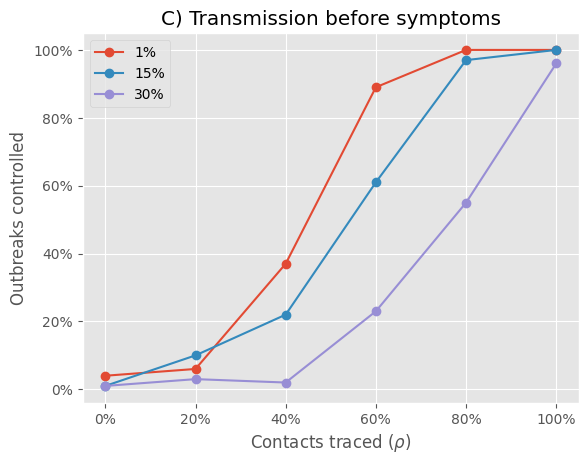

In [12]:
fig, ax = plt.subplots(1)

for transmission_before_symptoms_percentage in [1, 15, 30]:
    average_controlled_outbreaks = []
    for rho in rhos:
        params = ScenarioParameters(T = T, 
                            T_control = T_control,
                            initial_cases = 20,
                            rho = rho,
                            R_0 = 2.5,
                            onset_to_isolation = "short",
                            transmission_before_symptoms_percentage = transmission_before_symptoms_percentage,
                            subclinical_prob = 0)
        scen = Scenario(params)
        stats = scen.run_simulations(num_simulations = num_simulations)
        average_controlled_outbreaks.append(stats.controlled_percentage)
    plt.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=str(transmission_before_symptoms_percentage)+"%")

plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("C) Transmission before symptoms")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()

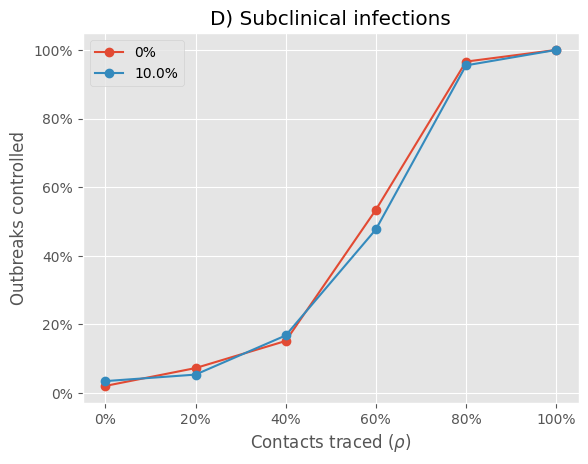

In [15]:
fig, ax = plt.subplots(1)

for subclinical_prob in [0, 0.1]:
    average_controlled_outbreaks = []
    for rho in rhos:
        params = ScenarioParameters(T = T, 
                                    T_control = T_control,
                                    initial_cases = 20,
                                    rho = rho,
                                    R_0 = 2.5,
                                    onset_to_isolation = "short",
                                    transmission_before_symptoms_percentage = 15,
                                    subclinical_prob = subclinical_prob)
        scen = Scenario(params)
        stats = scen.run_simulations(num_simulations = 1000)
        average_controlled_outbreaks.append(stats.controlled_percentage)    
    plt.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=str(subclinical_prob*100)+"%")

plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("D) Subclinical infections")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()

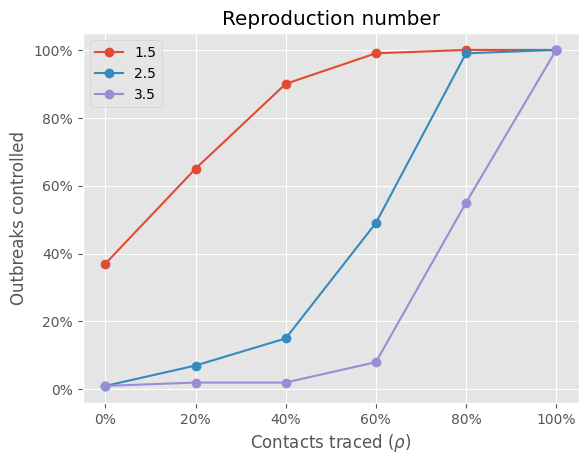

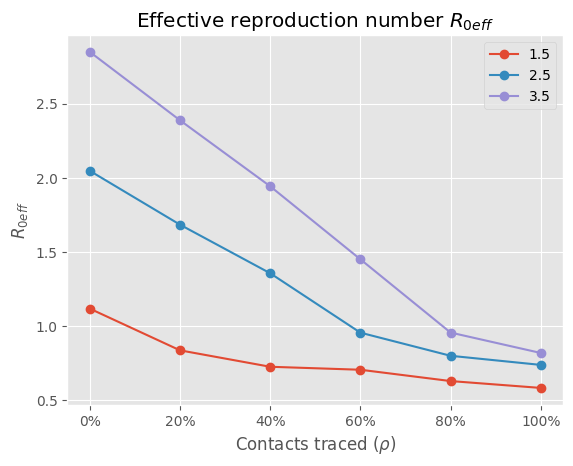

In [28]:
fig1, ax1 = plt.subplots(1)
fig2, ax2 = plt.subplots(1)

for R_0 in [1.5, 2.5, 3.5]:
    average_controlled_outbreaks = []
    effective_R_0 = []
    for rho in rhos:
        params = ScenarioParameters(T = T, 
                            T_control = T_control,
                            initial_cases = 20,
                            rho = rho,
                            R_0 = R_0,
                            onset_to_isolation = "short",
                            transmission_before_symptoms_percentage = 15,
                            subclinical_prob = 0)
        scen = Scenario(params)
        stats = scen.run_simulations(num_simulations = num_simulations)
        average_controlled_outbreaks.append(stats.controlled_percentage)
        effective_R_0.append(stats.effective_R_0_median)
    ax1.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=R_0)
    ax2.plot(rhos, effective_R_0, '-', marker = 'o', label=R_0)

plt.sca(ax1)
plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("Reproduction number")
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.sca(ax2)
plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"$R_{0eff}$")
plt.title("Effective reproduction number $R_{0eff}$")
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()